In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.sparse import coo_matrix
import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
gene_map = {
    "CD11c": "Itgax",
    "CD27" : "Cd27",
    "CD8a" : "Cd8a",
    "CD68" : "Cd68",
    "2" : "Thy1",
    "CD3" : "Cd3g",
    "CD44" : "Cd44",
    "CD5" : "Cd5",
    "CD4" : "Cd4",
    "CD29" : "Itgb1"
}

prot_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_protein_filter.csv"
rna_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_rna_raw.csv"

prot_data = pd.read_csv(prot_data_path)
rna_data = pd.read_csv(rna_data_path)

prot_data.columns = prot_data.columns.str.split("_").str[-1]
# rename the columns of the prot_data based on the gene_map
prot_data.rename(columns=gene_map, inplace=True)

# using the data in prot_data replace the columns in rna_data
rna_data.index = rna_data["Unnamed: 0"]
rna_data.drop("Unnamed: 0", axis=1, inplace=True)
prot_data.index = prot_data["Unnamed: 0"]
prot_data.drop("Unnamed: 0", axis=1, inplace=True)

# rna_coords
rna_coords = np.asarray(rna_data.index.str.split("_", expand=True))
rna_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in rna_coords])

# prot_coords
prot_coords = np.asarray(prot_data.index.str.split("_", expand=True))
prot_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in prot_coords])

# alignment the two matrix
def align_prot_rna_mtx(df, gene_name):
    data = df[gene_name]
    coords = np.asarray(data.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    # delete the data with coordination[1] less than 13
    x_mask_ind = coordination[:, 0] >= 13
    y_mask_ind = coordination[:, 1] <= 78
    mask_ind = x_mask_ind & y_mask_ind
    data = data[mask_ind]
    coordination = coordination[mask_ind]
    row_ind = coordination[:, 0] - 13
    col_ind = coordination[:, 1]
    data = data.values
    coo = coo_matrix((data, (row_ind, col_ind)), shape=np.max(coordination, axis=0)+1)
    csr = coo.tocsr()
    plt.scatter(row_ind, col_ind, c=data, cmap="inferno", s=2)
    plt.title(f"{gene_name} spatial expression")
    plt.colorbar()
    plt.show()
    return csr

# get the spatial expression of the gene_name
def get_spa_gene_exp(df, gene_name):
    df = df[gene_name]
    coords = np.asarray(df.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    row_ind = coordination[:,0]
    col_ind = coordination[:,1]
    data = df.values
    coo = coo_matrix((data, (row_ind, col_ind)), shape=np.max(coordination, axis=0)+1)
    csr = coo.tocsr()
    plt.scatter(row_ind, col_ind, c=data, cmap="inferno", s=2)
    plt.title(f"{gene_name} spatial expression")
    plt.colorbar()
    plt.show()
    return csr

def align_coord(df):
    coords = np.asarray(df.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    # delete the data with coordination[1] less than 13
    x_mask_ind = coordination[:, 0] >= 13
    y_mask_ind = coordination[:, 1] <= 78
    mask_ind = x_mask_ind & y_mask_ind
    df = df[mask_ind]
    coordination = coordination[mask_ind]
    row_ind = coordination[:, 0] - 13
    col_ind = coordination[:, 1]
    ind = [str(row) + "_" + str(col) for row, col in zip(row_ind, col_ind)]
    df.index = ind
    return df

prot_data = align_coord(prot_data)
prot_data.columns = prot_data.columns + "_prot"
combine_data = pd.concat([rna_data, prot_data], axis=1)
combine_data.fillna(0, inplace=True)

def get_adj_mtx(df):
    """
    define the x and y are close to 1 unit, the spots are neighbor
    """
    coords = np.asarray(df.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    adj_mtx = np.zeros((coordination.shape[0], coordination.shape[0]))
    for i in range(coordination.shape[0]):
        for j in range(coordination.shape[0]):
            # if the x and y are close to 1 unit, the spots are neighbor
            if abs(coordination[i, 0] - coordination[j, 0]) <= 1 and abs(coordination[i, 1] - coordination[j, 1]) <= 1:
                adj_mtx[i, j] = 1
    # set the diagonal of the adj_mtx to 0
    np.fill_diagonal(adj_mtx, 0)
    return adj_mtx

adj_mtx = get_adj_mtx(combine_data)

In [3]:
gene = "Cd3g"
prot_name = gene + "_prot"
# combine_data[gene], combine_data[prot_name]
prot_count_ni = adj_mtx.dot(combine_data[prot_name])
rna_count_ni = adj_mtx.dot(combine_data[gene])
ni_count = pd.DataFrame({"rna_count_ni": rna_count_ni, "prot_count_ni": prot_count_ni}, 
                            index=combine_data.index)
gene_data = pd.concat((combine_data[gene], combine_data[prot_name], ni_count), axis=1)
gene_data

,Cd3g,Cd3g_prot,rna_count_ni,prot_count_ni
37_3,0.0,0.0,1.0,0.0
23_65,0.0,4.0,0.0,161.0
78_72,0.0,0.0,0.0,4.0
94_32,0.0,201.0,7.0,1522.0
42_4,0.0,0.0,0.0,0.0
...,...,...,...,...
113_62,0.0,12.0,0.0,147.0
113_70,0.0,34.0,0.0,188.0
113_69,0.0,24.0,0.0,186.0
112_78,0.0,3.0,0.0,80.0


/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


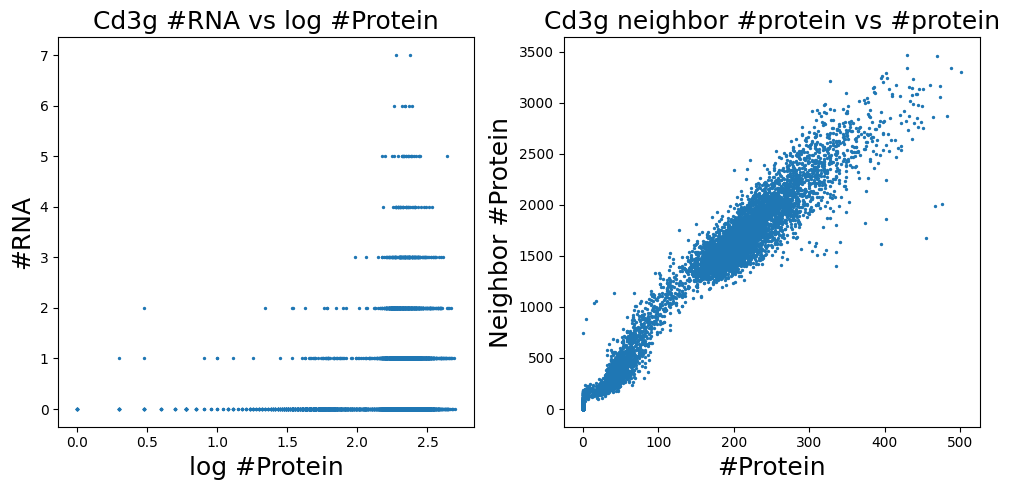

In [4]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(np.log10(gene_data["Cd3g_prot"]), gene_data["Cd3g"], s=2)
axs[0].set_title(f"{gene} #RNA vs log #Protein", fontsize=18)
axs[0].set_xlabel("log #Protein", fontsize=18)
axs[0].set_ylabel("#RNA", fontsize=18)
axs[1].scatter(gene_data["Cd3g_prot"], gene_data["prot_count_ni"], s=2)
axs[1].set_title(f"{gene} neighbor #protein vs #protein", fontsize=18)
axs[1].set_xlabel("#Protein", fontsize=18)
axs[1].set_ylabel("Neighbor #Protein", fontsize=18)
plt.tight_layout()
plt.show()

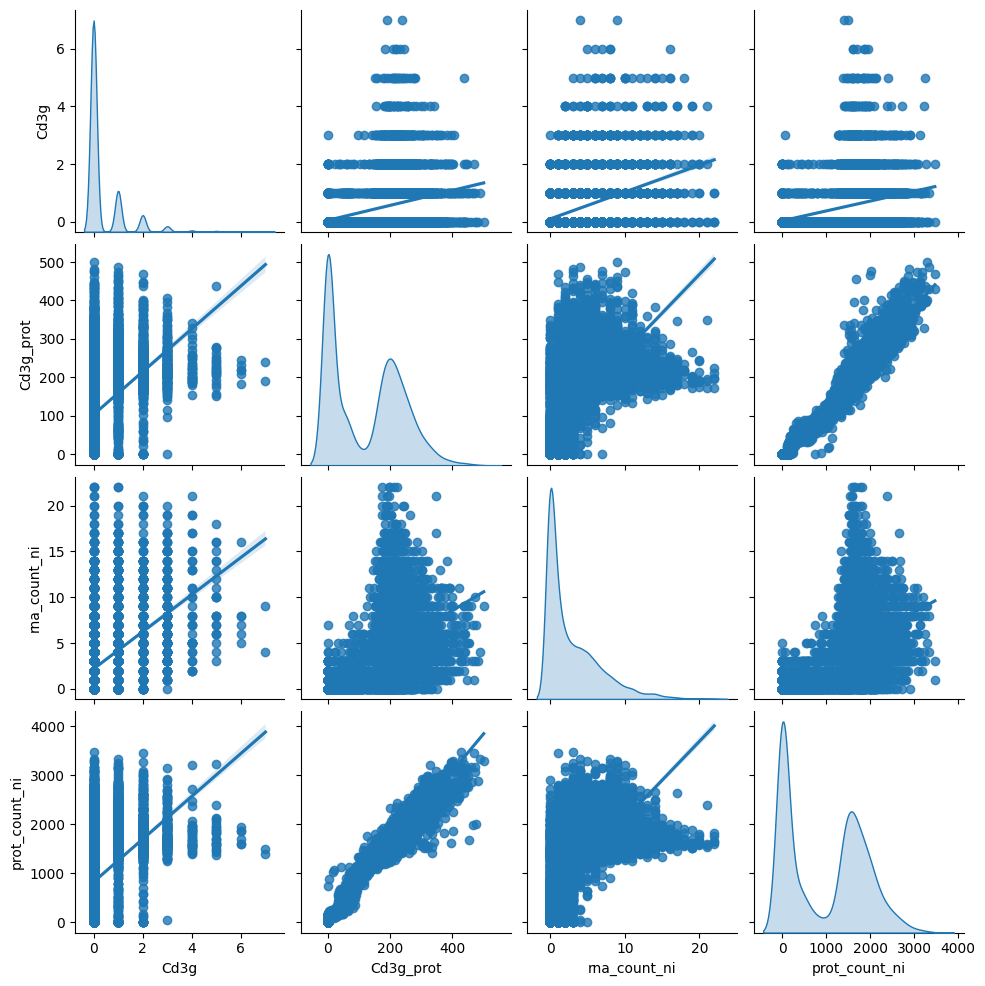

In [5]:
sns.pairplot(gene_data, kind="reg", diag_kind="kde")

In [6]:
from sklearn.linear_model import PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import poisson, nbinom, randint
from sklearn.utils import check_random_state

def log_transform(x):
    return np.log(x + 1)

def poisson_glm(X, y, alpha=0.0, fit_intercept=True):
    glm = Pipeline(steps=[
        ('scalar', StandardScaler),
        ('model', TransformedTargetRegressor(
            regressor=PoissonRegressor(
                alpha=alpha,
                fit_intercept=fit_intercept), 
            func=log_transform, 
            inverse_func=np.exp
            )
        )
    ])
    glm.fit(X, y)
    return glm

def nb_glm(X, y, alpha=0.0, fit_intercept=True):
    def nb_ll(y, pred, alpha):
        return -nbinom.logpmf(y, alpha, pred/(alpha+pred))
    glm = Pipeline(steps=[
        ('scalar', StandardScaler),
        ('model', TransformedTargetRegressor(
            regressor=TweedieRegressor(
                power=0,
                alpha=alpha,
                fit_intercept=fit_intercept,
                max_iter=1000,
                tol=1e-6,
                link='log',
                objective=nb_ll
            ),
            func=log_transform,
            inverse_func=np.exp
            )
        )
    ])
    glm.fit(X, y)
    return glm

def zip_glm(X, y, alpha=0.0, fit_intercept=True):
    # def zip_ll(y, pred, alpha):
    #     return -np.log(1-alpha) - poisson.logpmf(y, pred)
    glm = Pipeline(steps=[
        ('scalar', StandardScaler),
        ('model', TransformedTargetRegressor(
            regressor=GammaRegressor(
                alpha=alpha,
                fit_intercept=fit_intercept
            ),
            func=log_transform,
            inverse_func=np.exp)
        )]
    )
    param_grid = {
        'model__regressor__alpha': [0, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'model__regressor__fit_intercept': [True, False],
        'model__regressor__max_iter': [1000],
        'model__regressor__tol': [1e-6],
        'model__regressor__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    random_state = check_random_state(0)
    grid_search = GridSearchCV(glm, param_grid, cv=5, scoring='neg_bic', n_jobs=16, iid=False, verbose=1)
    grid_search.fit(X, y, model__sample_weight=random_state.randint(1, 100, size=len(y)))
    return grid_search.best_estimator_

def zinb_glm(X, y, alpha=0.0, fit_intercept=True):
    def zinb_ll(y, pred, alpha):
        return -nbinom.logpmf(y, alpha, pred/(alpha + pred))
    glm = Pipeline(steps=[
        ('scalar', StandardScaler()),
        ('model', TransformedTargetRegressor(
            regressor=TweedieRegressor(
                power=0,
                alpha=alpha,
                fit_intercept=fit_intercept,
                max_iter=1000,
                tol=1e-6,
                link='log',
                objective=zinb_ll
            ),
            func=log_transform,
            inverse_func=np.exp
            )
        )
    ])
    param_grid = {
        'model__regressor__alpha': [0, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'model__regressor__fit_intercept': [True, False],
        'model__regressor__max_iter': [1000],
        'model__regressor__tol': [1e-6],
        'model__regressor__link': ['log'],
        'model__regressor__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    random_state = check_random_state(0)
    grid_search = GridSearchCV(glm, param_grid, cv=5, scoring='neg_bic', n_jobs=16, iid=False, verbose=1)
    grid_search.fit(X, y, model__sample_weight=random_state.randint(1, 100, size=len(y)))
    return grid_search.best_estimator_

In [9]:
X = gene_data[["rna_count_ni", "prot_count_ni", "Cd3g_prot"]]
y = gene_data["Cd3g"]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [10]:
model = poisson_glm(X_train, y_train)
print(model)

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [27]:
def inverse_func(x):
    return np.exp(x)-1

glm = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('model', TransformedTargetRegressor(
        regressor=PoissonRegressor(
            alpha=1e-6,
            fit_intercept=True), 
        func=log_transform, 
        inverse_func=inverse_func
        )
    )],
    verbose=True,
)

In [28]:
glm.fit(X_train, y_train)
glm.score(X_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scalar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  18.8s


0.1969170100597495

In [19]:
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

X_transform = gene_data[["Cd3g_prot", "rna_count_ni"]]

poly = PolynomialFeatures(2, interaction_only=True)
poly.fit_transform(X_transform.values)

# def log_transform(x):
#     return np.log(x + 1)

# log_scale_transformer = make_pipeline(
#     FunctionTransformer(func=log_transform),
#     StandardScaler()
# )

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  4.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ...,
       [ 1., 24.,  0.,  0.],
       [ 1.,  3.,  0.,  0.],
       [ 1.,  6.,  0.,  0.]])

In [7]:
# combine_data
# adj_mtx
edge_index = adj_mtx.nonzero()
edge_index

(array([   0,    0,    0, ..., 8627, 8627, 8627]),
 array([ 977, 5110, 6944, ..., 8586, 8616, 8617]))

In [9]:
edge_index = np.asarray(edge_index)

In [10]:
edge_index

array([[   0,    0,    0, ..., 8627, 8627, 8627],
       [ 977, 5110, 6944, ..., 8586, 8616, 8617]])

In [11]:
combine_data.shape

(8628, 25828)

In [19]:
for i in range(1,11,2):
    print(f"{i*0.1:.1f}")

0.1
0.3
0.5
0.7
0.9


In [22]:
root_dir = "/home/wuxinchao/data/project/spatial-CITE-seq/mid_result"
combine_data.to_csv(f"{root_dir}/B01825A4_rna_prot_concat.csv")
edge_index = pd.DataFrame(edge_index)
edge_index.to_csv(f"{root_dir}/B01825A4_edge_index.csv")